# Analyse des dialogues dans l'Avare de Molière

## Choix du fichier source

*L'Avare* de Molière est disponible dans plusieurs formats différents. 
Cependant, tous ne se prêtent pas à une analyse sémantique d'une pièce de théâtre. 
Les formats reposant sur du texte brut (tels que Markdown ou iramuteq, et par extension, les fichiers ne contenant que les prises de parole) compliquent le triage des [didascalies](https://fr.wikipedia.org/wiki/Didascalie_(théâtre)) et autres blocs de texte insérés dans les scènes, et ne relevant pas directement du dialogue. 
Notre choix devra donc se porter sur un format plus structuré.
Nous pourrions tenter l'analyse des fichiers epub ou kindle, mais ce sont des formats destinés à la présentation, ce qui rendrait leur analyse inutilement complexe et coûteuse, alors que de meilleurs formats sont disponibles.

Les formats de fichier constituant de meilleurs candidats pour une analyse sémantique sont basés sur XML, qui permet la structuration du contenu : TEI (conçu par le *Text Encoding Initiative Consortium*), TXM (co-développé par l'École normale supérieure de Lyon et l'université de Franche-Comté), et HTML (le langage de balisage du web). 

Ces trois formats sont basés sur XML, et peuvent donc théoriquement être exploités avec une même API ([XPath](https://fr.wikipedia.org/wiki/XPath)), sans nécessiter de bibliothèque tierce. 

HTML présente toutefois des avantages considérables : son exploitation par, au minimum, quelques centaines de millions de sites web à travers le monde, et sa gouvernance par un consortium d'entreprises comme Apple, Google ou Mozilla outre-Atlantique, ou encore l'Inria en France. 
C'est le format qui a créé internet, et il est réutilisé dans des contextes très différents.
De plus, en tant que développeur web depuis 30 ans, l'auteur de la présente analyse ne cache pas son intérêt particulier pour ce format, avec lequel il est bien plus familier qu'avec les autres.

Nous poursuivrons donc cette étude avec le fichier `moliere_avare.html` [mis à disposition](http://dramacode.github.io/html/moliere_avare.html) par [dramacode](https://dramacode.github.io).

## Ouverture du fichier

Commençons par regrouper les importations, afin d'en avoir une vue d'ensemble.

In [1]:
# Parseur XML, requêtes XPath
import xml.etree.ElementTree as ET

# Analyse
import pandas as pd

# Utile pour la gestion des caractères accentués
import locale

# Nous permet de combiner deux listes de longueur indéterminée
from itertools import zip_longest

# Utilisation d'expressions régulières (regex)
import re

# Traçage de graphiques
import matplotlib.pyplot as plt

# Permet de définir et d'afficher la colormap des personnages
from itertools import cycle
import matplotlib.patches as mpatches

# Utiles aux calculs effectués pour les graphiques
import math
import numpy as np

# Dépendances pour le graphe final
from pathlib import Path
from jinja2 import Environment, FileSystemLoader

# Pose un certain nombre de problèmes pour l'exportation,
# en raison de sa nature dynamique (et écrit en javascript)
import pyvis
from pyvis.network import Network
import matplotlib.colors as mcolors
from IPython.display import HTML

In [2]:
# La définition de la locale nous permettra de gérer correctement les majuscules
# accentuées
locale.setlocale(locale.LC_COLLATE, "fr_FR.UTF-8")  # ou "fr_FR.UTF-8", "fr_FR" selon le système

ns = {"x": "http://www.w3.org/1999/xhtml"}
root = ET.parse("moliere_avare.html").getroot()

## Outils préliminaires

Nous travaillons sur une pièce de théâtre, par définition divisée en actes et en scènes.
Nous allons donc nous créer quelques outils pour accéder facilement à ces éléments structurés, que nous complèterons de diverses fonctions utilisées à plusieurs reprises dans notre étude.

In [3]:
# Nettoyage des titres
def clean_title(el, tag):
    return "".join(el.find(tag, ns).itertext()).replace("§", "").strip()

# Actes avec ordre explicite
def list_acts():
    acts = []

    for idx, act in enumerate(root.findall(".//x:section[@class='div1 act level2']", ns)):
        acts.append({
            "id": act.get("id"),
            "title": clean_title(act, "x:h2"),
            "node": act,
            "order": idx,
        })

    return acts

# Scènes d’un acte donné, avec ordre explicite
def list_scenes(act=None, act_id=None):
    if act is None:
        if act_id is None:
            raise ValueError("Un élément `act` ou un identifiant doit être spécifié")

        act = root.find(f".//x:section[@class='div1 act level2'][@id='{act_id}']", ns)

        if act is None:
            raise ValueError(f"Acte introuvable: {act_id}")

    scenes = []

    for idx, scene in enumerate(act.findall("x:section[@class='div2 scene level3']", ns)):
        scenes.append({
            "id": scene.get("id"),
            "title": clean_title(scene, "x:h3"),
            "node": scene,
            "order": idx,
        })

    return scenes

# On compacte les espaces pour calquer le comptage sur l'OBVIL
# Supprime les balises <i> de l'élément HTML soumis.
# Cela permet de ne conserver que les noms de personnages extraits des blocs de dialogue,
# sans les didascalies.
def text_without_i(el):
    parts = []

    if el.tag != f"{{{ns['x']}}}i" and el.text and el.text.strip():
        parts.append(el.text.strip())

    for child in el:
        if child.tag != f"{{{ns['x']}}}i":
            parts.extend(text_without_i(child))

        # on garde toujours le texte suivant, même si le noeud enfant est une balise <i>
        if child.tail and child.tail.strip():
            parts.append(child.tail.strip())

    return parts

# Formate le nom d'un acteur extrait d'un dialogue
def speaker_name(sp):
    name = " ".join(text_without_i(sp)).strip()

    # nettoyage simple de la ponctuation finale
    name = name.rstrip(",;:").strip()

    return name

# Résolution d'un nom d'acteur à partir de notre table de correspondance
alias_index = {}
def resolve_name(name):
    return alias_index.get(name, name)

# Extrait le texte brut d'un dialogue soumis sous la forme d'un élément HTML
def speech_text(sp):
    parts = []

    for p in sp.findall(".//x:p[@class='p autofirst']", ns):
        parts.extend(text_without_i(p))

    raw = " ".join(parts)
    return " ".join(raw.split()).strip()

# Compte le nombre de mots d'un texte brut.
# On utilise ici une regex simple dédiée à cet usage.
def word_count(txt):
    return len(re.findall(r"\b\w+\b", txt, flags=re.UNICODE))

# Conversion d'un texte en nombre de lignes (60 caractères par ligne)
def line_count(txt, line_length=60):
    return len(txt) / line_length if txt else 0

# Retourne l'acteur associé à une réplique (<div class="sp">)
def speech_actor(sp):
    speaker_el = sp.find("x:p[@class='speaker']", ns)

    if speaker_el is None:
        return ""

    return resolve_name(speaker_name(speaker_el))

# Liste les répliques d'une scène (par noeud ou identifiant) avec texte et nombre de mots
def scene_speeches(scene=None, scene_id=None):
    if scene is None:
        if scene_id is None:
            raise ValueError("Un élément `scene` ou un identifiant doit être spécifié")

        scene = root.find(f".//x:section[@class='div2 scene level3'][@id='{scene_id}']", ns)

        if scene is None:
            raise ValueError(f"Scène introuvable: {scene_id}")

    speeches = []

    for sp_div in scene.findall(".//x:div[@class='sp']", ns):
        speaker = speech_actor(sp_div)

        if not speaker:
            continue

        txt = speech_text(sp_div)

        speeches.append({
            "speaker": speaker,
            "text": txt,
            "word_count": word_count(txt),
            "node": sp_div,
        })

    return speeches

# Création d'une colormap associant une couleur à un personnage
def create_actors_colormap(personnages):
    # Définition d'une palette de couleurs pour les personnages
    palette = cycle(plt.cm.tab20.colors)
    color_map = {}

    for p in personnages:
        color_map[p] = next(palette)

    return color_map

Vérifions que nous obtenons bien la liste des actes et des scènes :

In [4]:
for act in list_acts():
    for scene in list_scenes(act=act["node"]):
        print ("Acte " + act["id"] + " - Scène " + scene["id"])

Acte I - Scène I01
Acte I - Scène I02
Acte I - Scène I03
Acte I - Scène I04
Acte I - Scène I05
Acte II - Scène II01
Acte II - Scène II02
Acte II - Scène II03
Acte II - Scène II04
Acte II - Scène II05
Acte III - Scène III01
Acte III - Scène III02
Acte III - Scène III03
Acte III - Scène III04
Acte III - Scène III05
Acte III - Scène III06
Acte III - Scène III07
Acte III - Scène III08
Acte III - Scène III09
Acte IV - Scène IV01
Acte IV - Scène IV02
Acte IV - Scène IV03
Acte IV - Scène IV04
Acte IV - Scène IV05
Acte IV - Scène IV06
Acte IV - Scène IV07
Acte V - Scène V01
Acte V - Scène V02
Acte V - Scène V03
Acte V - Scène V04
Acte V - Scène V05
Acte V - Scène V06


## Obtention de la liste des acteurs

La requête xpath suivante permet d'extraire la liste des acteurs donnée au début du fichier, autrement appelée [_dramatis personae_](https://fr.wikipedia.org/wiki/Dramatis_personæ_(théâtre)).

In [5]:
# Retourne une liste formatée des personnages définis dans la dramatis personae.
# Prend en compte les majuscules accentuées.
def dramatis_personae():
    rows = []

    # Requête xpath permettant d'obtenir la liste des balises <li> listant les acteurs
    for li in root.findall(".//x:div[@id='castList']//x:li", ns):
        # L'acteur se trouve dans une balise <span>
        span = li.find("x:span", ns)
        name = span.text.strip()

        # description = texte qui suit le <span> dans la même balise <li>
        desc = (span.tail or "").strip()

        if desc.startswith(","):
            desc = desc[1:].strip()

        rows.append({"Personnage": name, "Description": desc})

    return pd.DataFrame(rows)

dramatis_personae = dramatis_personae()

# Affichage de la liste
dramatis_personae

Personnage                                        Description
0         Harpagon  Père de Cléante et d'Élise, et Amoureux de Mar...
1          Cléante                 Fils d'Harpagon, Amant de Mariane.
2            Élise                Fille d'Harpagon, Amante de Valère.
3           Valère                  Fils d'Anselme, et Amant d'Élise.
4          Mariane            Amante de Cléante, et aimée d'Harpagon.
5          Anselme                      Père de Valère et de Mariane.
6          Frosine                                  Femme d'Intrigue.
7     Maitre Simon                                          Courtier.
8   Maitre Jacques                    Cuisinier et Cocher d'Harpagon.
9        La Flèche                                  Valet de Cléante.
10     Dame Claude                               Servante d'Harpagon.
11     Brindavoine                                laquais d'Harpagon.
12     La Merluche                                laquais d'Harpagon.
13  Le commissaire                                      et son clerc.

Nous pouvons déjà constater que le commissaire et son clerc sont considérés comme un acteur unique.
Nous verrons plus tard si cette information est importante (par exemple, si le clerc s'exprime en son nom propre).

Nous allons confronter cette liste avec la liste des protagonistes mentionnés en introduction de chaque scène, puis avec ceux qui interviennent "réellement", c'est-à-dire ceux qui ont une ligne de dialogue.
Cette étape devra nous permettre d'identifier des différences d'orthographe subtiles qu'il sera utile de gérer.

### Noms des personnages par scène

Nous allons itérer sur chaque acte, puis chaque scène, afin de consulter la liste des protagonistes. 
N'oublions pas que ces listes sont facultatives, et ne désignent pas les acteurs dotés d'une réplique.
Néanmoins, nous pourrions identifier des éléments potentiellement intéressants, tels que des orthographes différentes ou une anomalie quelconque.

In [6]:
def list_scene_protagonists():
    rows = []

    for act in list_acts():
        for scene in list_scenes(act=act["node"]):
            stage = scene["node"].find("x:div[@class='stage stage']", ns)

            # Si nous trouvons un noeud xpath pour cette requête, c'est un personnage
            if stage is not None:
                raw = "".join(stage.itertext()).strip()
                people = [p.strip() for p in raw.split(",") if p.strip()]
            else:
                people = []

            rows.append({
                "Acte": act["title"],
                "Scène": scene["title"],
                "Protagonistes": people,
            })

    return pd.DataFrame(rows)

df_scenes = list_scene_protagonists()
df_scenes

Acte           Scène  \
0   Acte Premier  Scène Première   
1   Acte Premier        Scène II   
2   Acte Premier       Scène III   
3   Acte Premier        Scène IV   
4   Acte Premier         Scène V   
5        Acte II  Scène Première   
6        Acte II        Scène II   
7        Acte II       Scène III   
8        Acte II        Scène IV   
9        Acte II         Scène V   
10      Acte III  Scène Première   
11      Acte III        Scène II   
12      Acte III       Scène III   
13      Acte III        Scène IV   
14      Acte III         Scène V   
15      Acte III        Scène VI   
16      Acte III       Scène VII   
17      Acte III      Scène VIII   
18      Acte III        Scène IX   
19       Acte IV  Scène Première   
20       Acte IV        Scène II   
21       Acte IV       Scène III   
22       Acte IV        Scène IV   
23       Acte IV         Scène V   
24       Acte IV        Scène VI   
25       Acte IV       Scène VII   
26        Acte V  Scène Première   
27        Acte V        Scène II   
28        Acte V       Scène III   
29        Acte V        Scène IV   
30        Acte V         Scène V   
31        Acte V        Scène VI   

                                        Protagonistes  
0                                     [Valère, Élise]  
1                                    [Cléante, Élise]  
2                               [Harpagon, La Flèche]  
3                          [Élise, Cléante, Harpagon]  
4                           [Valère, Harpagon, Élise]  
5                                [Cléante, La Flèche]  
6        [Maître Simon, Harpagon, Cléante, La Flèche]  
7                                 [Frosine, Harpagon]  
8                                [La Flèche, Frosine]  
9                                 [Harpagon, Frosine]  
10  [Harpagon, Cléante, Élise, Valère, Dame Claude...  
11                           [Maître Jacques, Valère]  
12                 [Frosine, Mariane, Maître Jacques]  
13                                 [Mariane, Frosine]  
14                       [Harpagon, Frosine, Mariane]  
15                [Élise, Harpagon, Mariane, Frosine]  
16       [Cléante, Harpagon, Élise, Mariane, Frosine]  
17  [Harpagon, Mariane, Frosine, Cléante, Brindavo...  
18  [Harpagon, Mariane, Cléante, Élise, Frosine, L...  
19                 [Cléante, Mariane, Élise, Frosine]  
20       [Harpagon, Cléante, Mariane, Élise, Frosine]  
21                                [Harpagon, Cléante]  
22                [Maître Jacques, Harpagon, Cléante]  
23                                [Cléante, Harpagon]  
24                               [La Flèche, Cléante]  
25                                                 []  
26              [Harpagon, Le Commissaire, son Clerc]  
27  [Maître Jacques, Harpagon, Le Commissaire, son...  
28  [Valère, Harpagon, le Commissaire, son Clerc, ...  
29  [Élise, Mariane, Frosine, Harpagon, Valère, Ma...  
30  [Anselme, Harpagon, Élise, Mariane, Frosine, V...  
31  [Cléante, Valère, Mariane, Élise, Frosine, Har...

Nous voyons ici que la scène VII de l'acte IV ne contient aucun protagoniste déclaré dans la liste attenante[^1], mais nous allons de toute façon la compléter par l'extraction individuelle des interventions concrètes de chaque acteur.

[^1]: Cette liste n'est pas obligatoire dans le contexte théâtral. Ici, on peut supposer que son absence est dûe à un monologue par exemple.

In [7]:
def list_scene_speakers():
    rows = []

    for act in list_acts():
        for scene in list_scenes(act=act["node"]):
            speakers, seen = [], set()

            for sp in scene["node"].findall(".//x:p[@class='speaker']", ns):
                name = speaker_name(sp)

                # On évite d'ajouter à la liste un acteur que l'on a déjà vu passer
                if name and name not in seen:
                    seen.add(name)
                    speakers.append(name)

            rows.append({
                "Acte": act["title"],
                "Scène": scene["title"],
                "Intervenants": speakers,
            })

    return pd.DataFrame(rows)

df_speakers = list_scene_speakers()
df_speakers

Acte           Scène  \
0   Acte Premier  Scène Première   
1   Acte Premier        Scène II   
2   Acte Premier       Scène III   
3   Acte Premier        Scène IV   
4   Acte Premier         Scène V   
5        Acte II  Scène Première   
6        Acte II        Scène II   
7        Acte II       Scène III   
8        Acte II        Scène IV   
9        Acte II         Scène V   
10      Acte III  Scène Première   
11      Acte III        Scène II   
12      Acte III       Scène III   
13      Acte III        Scène IV   
14      Acte III         Scène V   
15      Acte III        Scène VI   
16      Acte III       Scène VII   
17      Acte III      Scène VIII   
18      Acte III        Scène IX   
19       Acte IV  Scène Première   
20       Acte IV        Scène II   
21       Acte IV       Scène III   
22       Acte IV        Scène IV   
23       Acte IV         Scène V   
24       Acte IV        Scène VI   
25       Acte IV       Scène VII   
26        Acte V  Scène Première   
27        Acte V        Scène II   
28        Acte V       Scène III   
29        Acte V        Scène IV   
30        Acte V         Scène V   
31        Acte V        Scène VI   

                                         Intervenants  
0                                     [Valère, Élise]  
1                                    [Cléante, Élise]  
2                               [Harpagon, La Flèche]  
3                          [Harpagon, Cléante, Élise]  
4                           [Harpagon, Valère, Élise]  
5                                [Cléante, La Flèche]  
6        [Maître simon, Harpagon, La Flèche, Cléante]  
7                                 [Frosine, Harpagon]  
8                                [La Flèche, Frosine]  
9                                 [Harpagon, Frosine]  
10  [Harpagon, Maître Jacques, La Merluche, Brinda...  
11                           [Valère, Maître Jacques]  
12                          [Frosine, Maître Jacques]  
13                                 [Mariane, Frosine]  
14                                [Harpagon, Frosine]  
15                [Mariane, Élise, Harpagon, Frosine]  
16      [Cléante, Mariane, Harpagon, Frosine, Valère]  
17                            [Brindavoine, Harpagon]  
18           [La Merluche, Harpagon, Cléante, Valère]  
19                 [Cléante, Élise, Mariane, Frosine]  
20                         [Harpagon, Élise, Cléante]  
21                                [Harpagon, Cléante]  
22                [Maître Jacques, Cléante, Harpagon]  
23                                [Cléante, Harpagon]  
24                               [La Flèche, Cléante]  
25                                         [Harpagon]  
26                         [Le Commissaire, Harpagon]  
27         [Maître Jacques, Harpagon, Le Commissaire]  
28                 [Harpagon, Valère, Maître Jacques]  
29  [Harpagon, Valère, Élise, Maître Jacques, Fros...  
30  [Anselme, Harpagon, Valère, Mariane, Maître Ja...  
31  [Cléante, Harpagon, Mariane, Anselme, Le Commi...

In [8]:
# Tri localisé pour les intervenants et déduplication
intervenants_uniques = sorted(
    {name for names in df_speakers["Intervenants"] for name in names},
    key=locale.strxfrm
)

intervenants_df = pd.DataFrame({"Intervenant": intervenants_uniques})
intervenants_df

Intervenant
0          Anselme
1      Brindavoine
2          Cléante
3            Élise
4          Frosine
5         Harpagon
6        La Flèche
7      La Merluche
8   Le Commissaire
9   Maître Jacques
10    Maître simon
11         Mariane
12          Valère

On peut désormais identifier les différences avec la _dramatis personae_, afin de vérifier l'uniformité des orthographes.
Par corollaire, on pourra, en même temps, identifier les acteurs sans réplique.

In [9]:
acteurs_set = set(dramatis_personae["Personnage"])
intervenants_set = set(intervenants_uniques)

# On écarte les noms exactement identiques
communs = acteurs_set & intervenants_set
acteurs_only = sorted(acteurs_set - communs, key=locale.strxfrm)
intervenants_only = sorted(intervenants_set - communs, key=locale.strxfrm)

df_diff = pd.DataFrame(
    list(zip_longest(acteurs_only, intervenants_only)),
    columns=["Personnage (en-tête)", "Intervenant (répliques)"]
)

df_diff

Personnage (en-tête) Intervenant (répliques)
0          Dame Claude          Le Commissaire
1       Le commissaire          Maître Jacques
2       Maitre Jacques            Maître simon
3         Maitre Simon                    None

`None` indique simplement un remplissage par `zip_longest` pour que les deux listes aient la même taille.

On identifie bien deux orthographes différentes pour trois acteurs. La liste des personnages initiale omet les accents circonflexes de "Maître", "commissaire" est écrit en minuscule, et "Simon" a perdu sa majuscule.

Enfin, il est clair que Dame Claude n'a aucune réplique (puisqu'on ne la retrouve pas dans la liste des intervenants).

On peut donc créer une table de correspondance, associant un nom correctement orthographié avec les variantes que l'on peut trouver dans le texte initial. Nous utiliserons comme référence la graphie française correcte de "maître", et "Commissaire" avec une majuscule.

In [10]:
alias_map = {
    "Maître Jacques": {"Maître Jacques", "Maitre Jacques"},
    "Maître Simon": {"Maitre Simon", "Maître simon"},
    "Le Commissaire": {"Le Commissaire", "Le commissaire"},
}

alias_index = {alias: canon for canon, aliases in alias_map.items() for alias in aliases}

## Quantité de parole par acteur

Maintenant que nous disposons d'une liste uniformisée des noms des différents acteurs, nous pouvons analyser l'ensemble de la pièce et quantifier le texte prononcé par chaque acteur.

In [11]:
# TODO : Est-ce que cette fonction est redondante avec
# les fonctions utilitaires créées précédemment ?
def count_words_by_actor():
    rows = []

    for act in list_acts():
        for scene in list_scenes(act=act["node"]):
            for order, speech in enumerate(scene_speeches(scene=scene["node"])):
                txt = speech["text"]
                rows.append({
                    "Acte": act["title"],
                    "Scène": scene["title"],
                    "Ordre": order,
                    "Personnage": speech["speaker"],
                    "Texte": txt,
                    "Mots": speech["word_count"],
                    "Lignes": line_count(txt),
                })

    return pd.DataFrame(rows)

df_speeches = count_words_by_actor()
df_counts = df_speeches.groupby(["Acte", "Scène", "Personnage"], as_index=False)["Mots"].sum()
df_counts

Acte      Scène      Personnage  Mots
0   Acte II   Scène II         Cléante   127
1   Acte II   Scène II        Harpagon   171
2   Acte II   Scène II       La Flèche    12
3   Acte II   Scène II    Maître Simon   197
4   Acte II  Scène III         Frosine     1
..      ...        ...             ...   ...
90   Acte V   Scène VI         Cléante   130
91   Acte V   Scène VI        Harpagon    89
92   Acte V   Scène VI  Le Commissaire    26
93   Acte V   Scène VI         Mariane    36
94   Acte V   Scène VI  Maître Jacques    23

[95 rows x 4 columns]

Le comptage semble s'effectuer correctement, mais un tel tableau n'est pas digeste. 
On peut noter par exemple que "Acte Premier" est dilué au centre du tableau, en raison de la clause `groupby`, qui trie implicitement le tableau, et ignore donc notre tri initial.
Nous pouvons toutefois ignorer ce détail ici, et regrouper par personnage : de cette manière, nous aurons un aperçu global du temps de parole de chacun à travers l'oeuvre.

In [12]:
global_df = df_speeches.groupby(["Personnage"])["Mots"].sum()

moins_bavard_nom = global_df.idxmin()
moins_bavard_mots = global_df.min()

plus_bavard_nom = global_df.idxmax()
plus_bavard_mots = global_df.max()

print(f"Personnage le plus taciturne : {moins_bavard_nom} ({moins_bavard_mots} mots)")
print(f"Personnage le plus locace  : {plus_bavard_nom} ({plus_bavard_mots} mots)")

Personnage le plus taciturne : Brindavoine (43 mots)
Personnage le plus locace  : Harpagon (6132 mots)


Notons que nous avons déjà établi que Dame Claude n'avait aucune réplique, et bien que le Commissaire soit accompagné d'un clerc, ce dernier ne parle jamais non plus.

Montrons la proportion de dialogues par personnage à travers un diagramme circulaire :

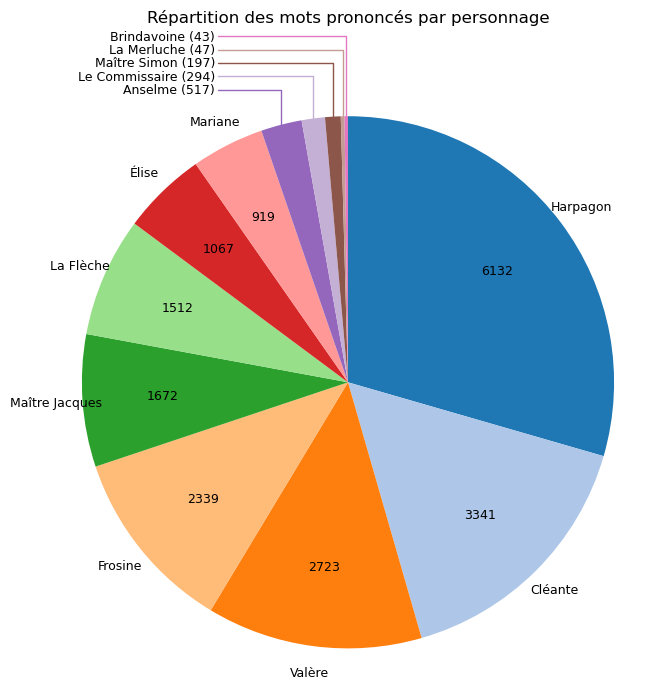

In [13]:
n_small = 5
y0, dy = 1.3, 0.05   # Positionnement du bloc des acteurs les moins locaces
x_col = -0.5

totaux = df_speeches.groupby("Personnage")["Mots"].sum().sort_values(ascending=False)
labels = totaux.index
values = totaux.values
color_map = create_actors_colormap(labels)
colors = [color_map[p] for p in labels]

fig, ax = plt.subplots(figsize=(7, 7))
wedges, _ = ax.pie(values, colors=colors, startangle=90, counterclock=False, normalize=True)

small_roles = global_df.sort_values().head(n_small)  # les moins bavards, ordre croissant

# Placement de l'étiquette pour les petits rôles
for i, (name, val) in enumerate(small_roles.items()):
    idx = labels.get_loc(name)
    w = wedges[idx]

    theta = np.deg2rad((w.theta1 + w.theta2) / 2)
    xw, yw = np.cos(theta), np.sin(theta)
    xpos, ypos = x_col, y0 - i * dy

    ax.annotate(
        f"{name} ({val})",
        xy=(xw, yw), xytext=(xpos, ypos),
        ha="right", va="center", fontsize=9,
        arrowprops=dict(
            arrowstyle="-",
            color=colors[idx],
            lw=1,
            connectionstyle="angle,angleA=0,angleB=90",
            shrinkA=0, shrinkB=0,
        ),
    )

# Autres rôles : nom autour + valeur au centre
for idx, name in enumerate(labels):
    if name in small_roles.index:
        continue

    w = wedges[idx]
    theta = np.deg2rad((w.theta1 + w.theta2) / 2)
    r_label, r_value = 1.1, 0.7

    ax.text(r_label * np.cos(theta), r_label * np.sin(theta), name, ha="center", va="center", fontsize=9)
    ax.text(r_value * np.cos(theta), r_value * np.sin(theta), str(totaux[name]), ha="center", va="center", fontsize=9, color="black")

ax.set_title("Répartition des mots prononcés par personnage", pad=50)
ax.axis("equal")
plt.tight_layout()


### Statistiques complémentaires

Inspirées des tableaux de l'OBVIL, nous examinons la place de chaque personnage et les relations directes entre interlocuteurs (une ligne = 60 caractères).
Commençons par la "Table des rôles" :

In [14]:
# Agrégats au niveau des scènes
scene_totals = (df_speeches.groupby(["Acte", "Scène"], as_index=False)
                .agg(scene_lines=("Lignes", "sum"),
                     participants=("Personnage", "nunique")))
scene_totals["textexpers"] = scene_totals["scene_lines"] * scene_totals["participants"]
scene_totals["SceneKey"] = scene_totals["Acte"] + " | " + scene_totals["Scène"]

total_lines_play = scene_totals["scene_lines"].sum()
textexpers_total = scene_totals["textexpers"].sum()

# Statistiques par personnage
speech_stats = df_speeches.groupby("Personnage").agg(
    repl=("Texte", "count"),
    text_lines=("Lignes", "sum"),
)

presence = (df_speeches[["Acte", "Scène", "Personnage"]]
            .drop_duplicates()
            .merge(scene_totals[["Acte", "Scène", "scene_lines", "textexpers"]],
                   on=["Acte", "Scène"], how="left"))

presence_stats = presence.groupby("Personnage").agg(
    scenes=("Scène", "count"),
    presence_lines=("scene_lines", "sum"),
    textexpers=("textexpers", "sum"),
)

roles = speech_stats.join(presence_stats, how="outer").fillna(0)

# Ajout des rôles muets (ex : Dame Claude) pour qu'ils apparaissent dans le tableau
for name in (resolve_name(p) for p in dramatis_personae["Personnage"]):
    if name not in roles.index:
        roles.loc[name] = 0

roles["repl_moy"] = roles["text_lines"] / roles["repl"]
roles["presence_pct"] = roles["presence_lines"] / total_lines_play
roles["text_pct"] = roles["text_lines"] / total_lines_play
roles["text_presence_pct"] = roles["text_lines"] / roles["presence_lines"]
roles["textexpers_pct"] = roles["textexpers"] / textexpers_total
roles["interlocution"] = roles["textexpers"] / roles["presence_lines"]

roles = roles.replace([np.inf, -np.inf], 0).fillna(0)

# Ordre basé sur la distribution initiale
role_order = [name for name in (resolve_name(p) for p in dramatis_personae["Personnage"]) if name in roles.index]
role_order += [r for r in roles.index if r not in role_order]

roles = roles.loc[role_order]

# Ligne globale
all_row = pd.Series({
    "scenes": scene_totals.shape[0],
    "repl": len(df_speeches),
    "repl_moy": df_speeches["Lignes"].sum() / len(df_speeches),
    "presence_lines": total_lines_play,
    "presence_pct": 1.0,
    "text_lines": df_speeches["Lignes"].sum(),
    "text_pct": 1.0,
    "text_presence_pct": df_speeches["Lignes"].sum() / total_lines_play if total_lines_play else 0,
    "textexpers": textexpers_total,
    "textexpers_pct": 1.0,
    "interlocution": textexpers_total / total_lines_play if total_lines_play else 0,
})

roles = pd.concat([
    pd.DataFrame({"Personnage": ["[TOUS]"]}).set_index("Personnage").assign(**all_row),
    roles
])

roles.index.name = "Rôle"

# Quelques utilitaires spécifiques

def format_number(value, decimals=0):
    fmt = f"{value:,.{decimals}f}"
    return fmt.replace(",", " ").replace(".", ",")
def format_lines(value, decimals=0):
    return f"{format_number(round(value, decimals), decimals)} l."
def format_percent(value, decimals=0):
    return f"{format_number(value * 100, decimals)} %"
def format_people(value):
    return f"{format_number(value, 1)} pers."

roles_display = roles.reset_index()
roles_display["Scènes"] = roles_display["scenes"].fillna(0).astype(int).astype(str) + " sc."
roles_display["Répl."] = roles_display["repl"].fillna(0).astype(int).astype(str) + " répl."
roles_display["Répl. moy."] = roles_display["repl_moy"].apply(lambda v: format_lines(v, 1))
roles_display["Présence"] = roles_display.apply(
    lambda r: f"{format_lines(r['presence_lines'])}" + (f" ({format_percent(r['presence_pct'])})" if r["presence_lines"] else ""),
    axis=1,
)
roles_display["Texte"] = roles_display.apply(
    lambda r: f"{format_lines(r['text_lines'])}" + (f" ({format_percent(r['text_pct'])})" if r["text_lines"] else ""),
    axis=1,
)
roles_display["Texte % prés."] = roles_display["text_presence_pct"].apply(lambda v: format_percent(v, 0))
roles_display["Texte × pers."] = roles_display.apply(
    lambda r: f"{format_lines(r['textexpers'])} ({format_percent(r['textexpers_pct'])})",
    axis=1,
)
roles_display["Interlocution"] = roles_display["interlocution"].apply(format_people)

roles_table = roles_display[["Rôle", "Scènes", "Répl.", "Répl. moy.", "Présence", "Texte", "Texte % prés.", "Texte × pers.", "Interlocution"]]
roles_table


Rôle  Scènes      Répl. Répl. moy.          Présence  \
0           [TOUS]  32 sc.  959 répl.     1,8 l.  1 769 l. (100 %)   
1         Harpagon  23 sc.  354 répl.     1,5 l.   1 296 l. (73 %)   
2          Cléante  14 sc.  161 répl.     1,8 l.     900 l. (51 %)   
3            Élise   9 sc.   51 répl.     1,8 l.     681 l. (39 %)   
4           Valère   9 sc.  101 répl.     2,3 l.     695 l. (39 %)   
5          Mariane   6 sc.   31 répl.     2,5 l.     359 l. (20 %)   
6          Anselme   2 sc.   20 répl.     2,3 l.      143 l. (8 %)   
7          Frosine  10 sc.   60 répl.     3,3 l.     466 l. (26 %)   
8     Maître Simon   1 sc.    5 répl.     3,2 l.       44 l. (2 %)   
9   Maître Jacques   9 sc.   85 répl.     1,6 l.     557 l. (32 %)   
10       La Flèche   5 sc.   66 répl.     2,0 l.     255 l. (14 %)   
11     Dame Claude   0 sc.    0 répl.     0,0 l.              0 l.   
12     Brindavoine   2 sc.    3 répl.     1,1 l.      166 l. (9 %)   
13     La Merluche   2 sc.    5 répl.     0,9 l.     175 l. (10 %)   
14  Le Commissaire   3 sc.   17 répl.     1,5 l.      110 l. (6 %)   

               Texte Texte % prés.     Texte × pers. Interlocution  
0   1 769 l. (100 %)         100 %  5 847 l. (100 %)     3,3 pers.  
1      514 l. (29 %)          40 %   4 729 l. (81 %)     3,7 pers.  
2      285 l. (16 %)          32 %   3 486 l. (60 %)     3,9 pers.  
3        92 l. (5 %)          13 %   2 667 l. (46 %)     3,9 pers.  
4      232 l. (13 %)          33 %   3 067 l. (52 %)     4,4 pers.  
5        79 l. (4 %)          22 %   1 638 l. (28 %)     4,6 pers.  
6        45 l. (3 %)          32 %     749 l. (13 %)     5,3 pers.  
7      201 l. (11 %)          43 %   1 465 l. (25 %)     3,1 pers.  
8        16 l. (1 %)          37 %      175 l. (3 %)     4,0 pers.  
9       140 l. (8 %)          25 %   2 670 l. (46 %)     4,8 pers.  
10      132 l. (7 %)          52 %     598 l. (10 %)     2,3 pers.  
11              0 l.           0 %        0 l. (0 %)     0,0 pers.  
12        3 l. (0 %)           2 %   1 146 l. (20 %)     6,9 pers.  
13        5 l. (0 %)           3 %   1 189 l. (20 %)     6,8 pers.  
14       26 l. (1 %)          24 %      418 l. (7 %)     3,8 pers.

Il existe des différences entre le tableau que nous avons généré et celui de l'OBVIL.
Ces différences peuvent être attribuées à :

- une méthode de nettoyage des lignes différente (nous avons opté pour un nettoyage agressif des espaces surnuméraires)
- une gestion des décimales différentes (est-ce que l'OBVIL arrondi à l'entier supérieur ou inférieur, ou tronque les décimales ?)

Ces différences affectent mathématiquement les statistiques qui découlent de ce comptage, notamment l'interlocution.

### Statistiques par relation

Chaque relation s'appuie sur l'enchaînement de répliques adjacentes entre deux personnages (monologues inclus), ce qui reflète les échanges directs plutôt que la simple coprésence sur scène.


In [15]:
from collections import defaultdict

# Accumulateur : pour chaque relation (acteur seul - monologues) ou (acteurA, acteurB),
# on stocke les lignes, le nombre de répliques, les scènes concernées,
# les lignes de présence cumulées et un poids d’interlocution (lignes × nb de participants).
relation_stats = defaultdict(lambda: {
    "lines": defaultdict(float),
    "counts": defaultdict(int),
    "scenes": set(),
    "presence_lines": 0.0,
    "interlocution_weight": 0.0,
})

scene_lookup = scene_totals.set_index(["Acte", "Scène"])[["scene_lines", "participants"]]

for (act, scene), scene_df in df_speeches.groupby(["Acte", "Scène"]):
    scene_df = scene_df.sort_values("Ordre")
    speakers = scene_df["Personnage"].tolist()
    lines = scene_df["Lignes"].tolist()
    scene_lines = scene_lookup.loc[(act, scene), "scene_lines"]
    participants = scene_lookup.loc[(act, scene), "participants"]
    scene_key = f"{act} | {scene}"

    # Scène à un seul intervenant : on enregistre un monologue
    if len(set(speakers)) == 1:
        actor = speakers[0]
        stats = relation_stats[(actor,)]
        stats["lines"][actor] += scene_lines
        stats["counts"][actor] += len(speakers)
        stats["scenes"].add(scene_key)
        stats["presence_lines"] += scene_lines
        stats["interlocution_weight"] += scene_lines * participants
        continue

    relations_here = set()
    
    # Pour chaque changement d’intervenant, on attribue les lignes du locuteur au duo (ordre ignoré)
    for speaker, next_speaker, speaker_lines in zip(speakers, speakers[1:], lines):
        if speaker == next_speaker:
            continue
            
        key = tuple(sorted((speaker, next_speaker)))
        stats = relation_stats[key]
        stats["lines"][speaker] += speaker_lines
        stats["counts"][speaker] += 1
        stats["scenes"].add(scene_key)
        relations_here.add(key)

    # On ajoute la présence et l’interlocution une seule fois par scène et par relation
    for key in relations_here:
        stats = relation_stats[key]
        stats["presence_lines"] += scene_lines
        stats["interlocution_weight"] += scene_lines * participants

role_order_index = {name: idx for idx, name in enumerate(role_order)}

def relation_sort_key(rel):
    if len(rel) == 1:
        return (role_order_index.get(rel[0], len(role_order_index)), -1)
    
    a, b = rel
    
    return (
        min(role_order_index.get(a, len(role_order_index)), role_order_index.get(b, len(role_order_index))),
        max(role_order_index.get(a, len(role_order_index)), role_order_index.get(b, len(role_order_index))),
    )

relation_rows = []

for rel in sorted(relation_stats, key=relation_sort_key):
    data = relation_stats[rel]
    total_lines = sum(data["lines"].values())

    # On ignore les relations sans matière (moins de 2 lignes au total)
    if total_lines < 2:
        continue
        
    # On ignore les relations où au moins un protagoniste n’a jamais prononcé de réplique dans ce duo
    if len(rel) > 1 and any(data["counts"].get(actor, 0) == 0 for actor in rel):
        continue

    scenes_count = len(data["scenes"])
    interlocution = data["interlocution_weight"] / data["presence_lines"] if data["presence_lines"] else 0

    parts = []
    
    for actor in rel:
        actor_lines = data["lines"].get(actor, 0)
        actor_repl = data["counts"].get(actor, 0)
        avg_lines = actor_lines / actor_repl if actor_repl else 0
        share = actor_lines / total_lines if total_lines else 0
        
        parts.append(
            f"{format_lines(actor_lines)} ({format_percent(share)}) {actor_repl} répl. {format_lines(avg_lines, 1)}"
        )

    relation_rows.append({
        "Relation": " / ".join(rel),
        "Détail": " - ".join(parts),
        "Scènes": f"{scenes_count} sc.",
        "Texte": f"{format_lines(total_lines)} ({format_percent(total_lines / total_lines_play)})",
        "Interlocution": format_people(interlocution),
    })

relations_table = pd.DataFrame(relation_rows)
relations_table

Relation  \
0                          Harpagon   
1                Cléante / Harpagon   
2                  Harpagon / Élise   
3                 Harpagon / Valère   
4                Harpagon / Mariane   
5                Anselme / Harpagon   
6                Frosine / Harpagon   
7           Harpagon / Maître Simon   
8         Harpagon / Maître Jacques   
9              Harpagon / La Flèche   
10           Brindavoine / Harpagon   
11           Harpagon / La Merluche   
12        Harpagon / Le Commissaire   
13                  Cléante / Élise   
14                Cléante / Mariane   
15                Cléante / Frosine   
16         Cléante / Maître Jacques   
17              Cléante / La Flèche   
18                   Valère / Élise   
19                  Mariane / Élise   
20                 Mariane / Valère   
21                 Anselme / Valère   
22          Maître Jacques / Valère   
23                Frosine / Mariane   
24         Frosine / Maître Jacques   
25              Frosine / La Flèche   
26  Le Commissaire / Maître Jacques   

                                               Détail Scènes          Texte  \
0                       33 l. (100 %) 1 répl. 32,7 l.  1 sc.    33 l. (2 %)   
1   135 l. (49 %) 97 répl. 1,4 l. - 140 l. (51 %) ...  9 sc.  275 l. (16 %)   
2   41 l. (60 %) 28 répl. 1,5 l. - 28 l. (40 %) 28...  6 sc.    69 l. (4 %)   
3   96 l. (44 %) 65 répl. 1,5 l. - 121 l. (56 %) 5...  7 sc.  217 l. (12 %)   
4   9 l. (39 %) 7 répl. 1,2 l. - 13 l. (61 %) 5 ré...  2 sc.    22 l. (1 %)   
5   25 l. (71 %) 11 répl. 2,2 l. - 10 l. (29 %) 8 ...  2 sc.    35 l. (2 %)   
6   128 l. (70 %) 39 répl. 3,3 l. - 56 l. (30 %) 3...  5 sc.  184 l. (10 %)   
7   5 l. (22 %) 3 répl. 1,5 l. - 16 l. (78 %) 4 ré...  1 sc.    20 l. (1 %)   
8   58 l. (38 %) 49 répl. 1,2 l. - 94 l. (62 %) 51...  7 sc.   153 l. (9 %)   
9   35 l. (62 %) 33 répl. 1,1 l. - 22 l. (38 %) 33...  1 sc.    57 l. (3 %)   
10  1 l. (38 %) 2 répl. 0,7 l. - 2 l. (62 %) 2 rép...  2 sc.     4 l. (0 %)   
11  1 l. (11 %) 1 répl. 0,6 l. - 5 l. (89 %) 5 rép...  2 sc.     5 l. (0 %)   
12  11 l. (53 %) 10 répl. 1,1 l. - 10 l. (47 %) 9 ...  3 sc.    21 l. (1 %)   
13  66 l. (84 %) 10 répl. 6,6 l. - 13 l. (16 %) 9 ...  2 sc.    78 l. (4 %)   
14  31 l. (60 %) 12 répl. 2,6 l. - 21 l. (40 %) 10...  3 sc.    52 l. (3 %)   
15  3 l. (8 %) 5 répl. 0,6 l. - 37 l. (92 %) 6 rép...  2 sc.    40 l. (2 %)   
16  14 l. (51 %) 8 répl. 1,8 l. - 14 l. (49 %) 8 r...  1 sc.    28 l. (2 %)   
17  31 l. (27 %) 25 répl. 1,2 l. - 85 l. (73 %) 26...  3 sc.   116 l. (7 %)   
18  65 l. (59 %) 11 répl. 5,9 l. - 45 l. (41 %) 11...  2 sc.   110 l. (6 %)   
19  1 l. (23 %) 2 répl. 0,6 l. - 4 l. (77 %) 1 rép...  2 sc.     6 l. (0 %)   
20  3 l. (41 %) 1 répl. 2,6 l. - 4 l. (59 %) 3 rép...  1 sc.     6 l. (0 %)   
21  19 l. (47 %) 8 répl. 2,4 l. - 22 l. (53 %) 7 r...  1 sc.    41 l. (2 %)   
22  18 l. (49 %) 14 répl. 1,3 l. - 19 l. (51 %) 18...  4 sc.    37 l. (2 %)   
23  18 l. (48 %) 6 répl. 3,0 l. - 20 l. (52 %) 7 r...  4 sc.    38 l. (2 %)   
24  1 l. (42 %) 1 répl. 1,0 l. - 1 l. (58 %) 2 rép...  2 sc.     2 l. (0 %)   
25  11 l. (42 %) 5 répl. 2,3 l. - 16 l. (58 %) 5 r...  1 sc.    28 l. (2 %)   
26  13 l. (76 %) 7 répl. 1,8 l. - 4 l. (24 %) 5 ré...  1 sc.    17 l. (1 %)   

   Interlocution  
0      1,0 pers.  
1      4,6 pers.  
2      4,7 pers.  
3      4,9 pers.  
4      4,9 pers.  
5      5,3 pers.  
6      3,0 pers.  
7      4,0 pers.  
8      4,9 pers.  
9      2,0 pers.  
10     6,9 pers.  
11     6,8 pers.  
12     3,8 pers.  
13     3,0 pers.  
14     4,8 pers.  
15     4,5 pers.  
16     3,0 pers.  
17     2,5 pers.  
18     2,5 pers.  
19     4,0 pers.  
20     5,0 pers.  
21     5,0 pers.  
22     5,2 pers.  
23     4,1 pers.  
24     4,7 pers.  
25     2,0 pers.  
26     3,0 pers.

Bien que le décompte des lignes diffère toujours de celui de l'OBVIL (comme attendu et pour les mêmes raisons que précédemment), l'interlocution est identique.
En effet, les écarts de comptage de lignes n’affectent pas l’interlocution ; seule une différence de liste d’intervenants par scène la ferait varier.

Voyons maintenant si nous parvenons à reproduire le graphique proposé par l'OBVIL :

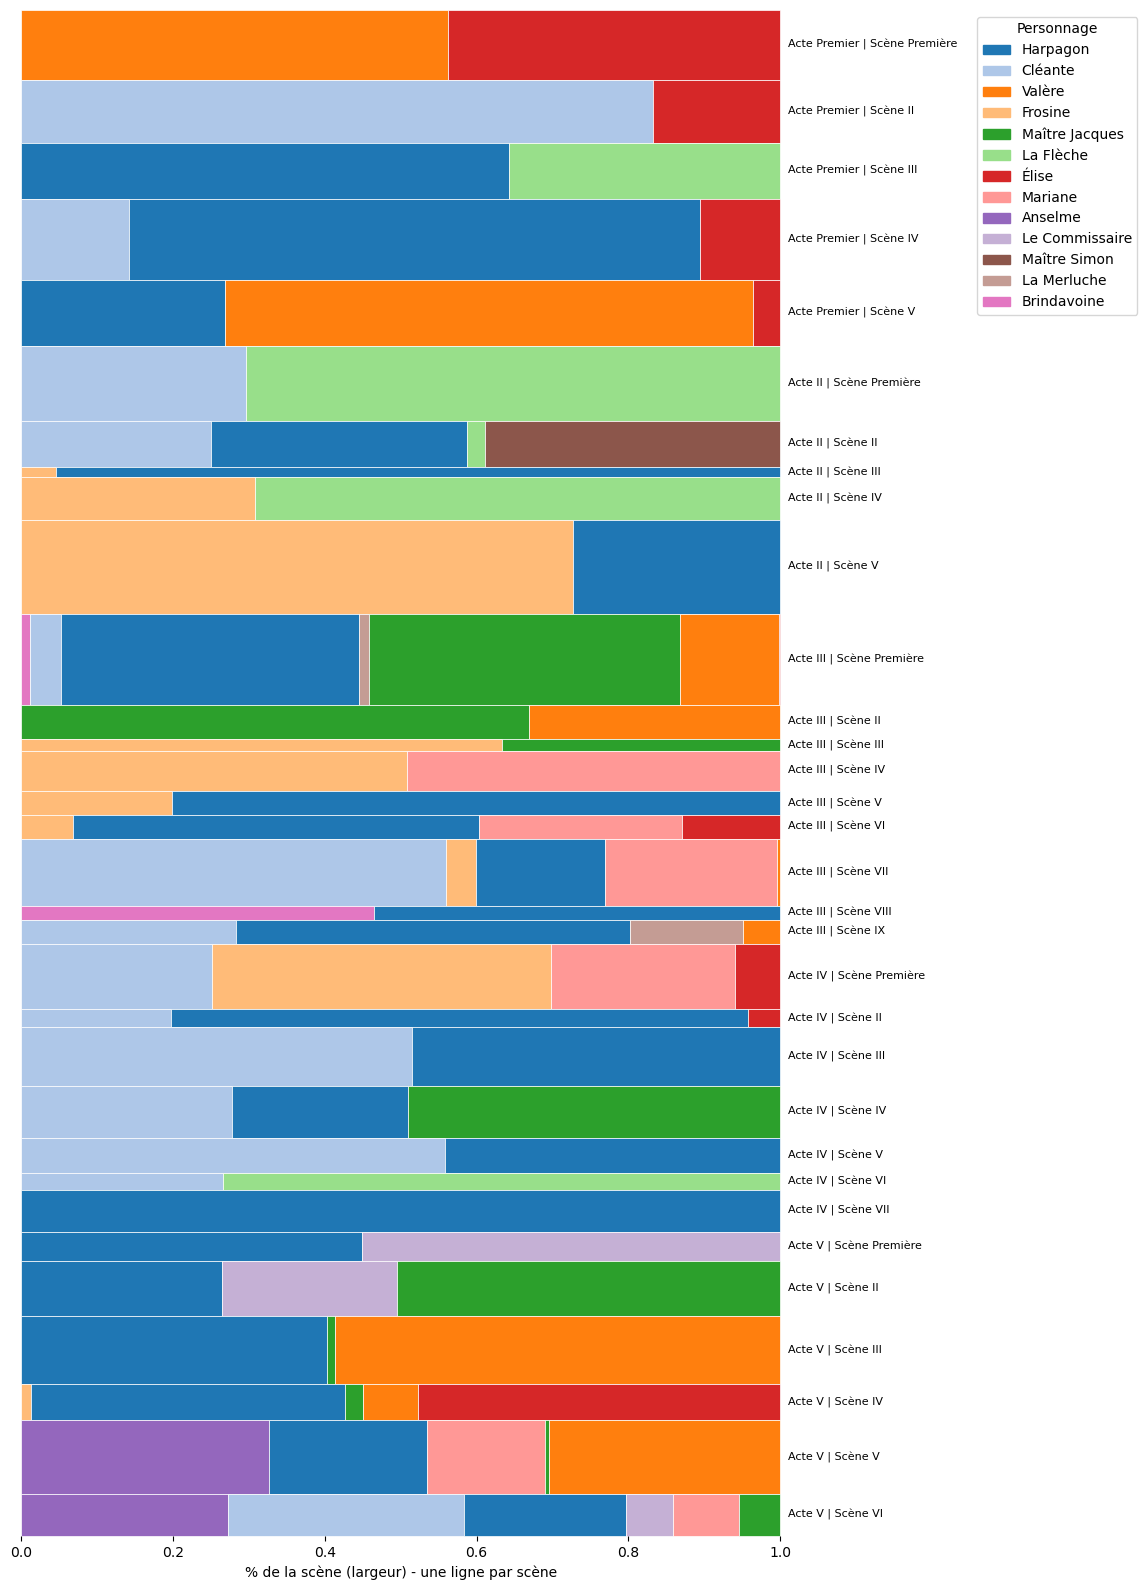

In [16]:
# Ordonnancement des actes et des scènes
# On affichera les labels bruts ("Acte Premier") mais on utilisera un ordre "naturel"
scene_order = []

for act in list_acts():
    for sc in list_scenes(act=act["node"]):
        scene_order.append(f"{act['title']} | {sc['title']}")

# Préparation des données
df = df_counts.copy()

# Création d'une clé unique pour identifier un couple acte/scène
# Cela permet de forcer l'ordre d'affichage, au lieu de suivre un ordre alphabétique
# qui noierait "Acte Premier" au milieu de la liste, par exemple
df["SceneKey"] = pd.Categorical(df["Acte"] + " | " + df["Scène"], categories=scene_order, ordered=True)

# Obtention du pourcentage que représente un dialogue particulier au sein d'une scène
df["share"] = df["Mots"] / df.groupby("SceneKey", observed=False)["Mots"].transform("sum")

# Calcul du total de mots pour une scène donnée
totals = df.groupby("SceneKey", observed=False)["Mots"].sum()

# Paramétrage du graphique
gap = 0 # Espace vertical ajouté entre deux scènes
label_fs = 8 # Taille de la police des étiquettes
min_target = 10  # Hauteur minimale souhaitée

# Définition de la hauteur d'une scène.
# Nous utilisons ici une fonction racine carré.
# Le but de ce calcul est d'éviter que les scènes contenant le moins de mots
# se trouvent compressées en une ligne si fine qu'il ne serait pas possible
# de distinguer les différents protagonistes.
# On sacrifie donc le rapport proportionnel strict au profit d'une meilleure
# lisibilité.
def scene_height(total):
    return max(min_target, math.sqrt(total) * factor)

create_actors_colormap(df["Personnage"].unique())

# Calcul de l'échelle des scènes : évite qu'une scène courte soit
# représentée par une ligne trop fine pour être distinguée
min_total = totals.min()
factor = min_target / math.log1p(min_total)

figure, axis = plt.subplots(figsize=(12, len(scene_order) * 0.5))

# Affichage de la colormap des personnages
handles = [mpatches.Patch(color=col, label=name) for name, col in color_map.items()]
axis.legend(handles=handles, title="Personnage", bbox_to_anchor=(1.25, 1), loc="upper left")

y = 0 # "Curseur" vertical permettant de positionner les scènes

# Traçage des scènes
for scene in scene_order:
    scene_rows = df[df["SceneKey"] == scene]
    h = scene_height(totals.loc[scene])

    left = 0

    for _, row in scene_rows.iterrows():
        # broken_barth est la méthode nous permettant de tracer des barres
        # horizontales juxtaposés
        axis.broken_barh([(left, row["share"])], (y, h),
                       facecolors=color_map[row["Personnage"]],
                       edgecolors="white", linewidth=0.5)

        # Décalage horizontal de la prochaine barre
        left += row["share"]

    # Étiquette correspondant à la scène
    axis.text(1.01, y + h/2, scene, va="center", fontsize=label_fs)

    # Décalage vertical de la prochaine scène
    y += h + gap

axis.set_xlim(0, 1)
axis.set_ylim(0, y)
axis.invert_yaxis()  # Acte I en haut
axis.set_xlabel("% de la scène (largeur) - une ligne par scène")
axis.set_yticks([]) # On masque l'ordonnée à gauche
axis.spines[["top", "right", "left", "bottom"]].set_visible(False) # On masque les délimitations du graphique
plt.tight_layout()

L'ordre des dialogues est respecté sur ce graphique, contrairement au graphique de l'OBVIL.
Par exemple, dans la deuxième scène du premier acte, Cléante est bien la première à prendre la parole, et non Élise.

## Graphe réseau des dialogues

Ici, nous allons représenter les dialogues par un graphe réseau.
Nous allons essayer de reproduire le [graphe](https://obtic.huma-num.fr/obvil-web/corpus/moliere/moliere_avare) proposé par l'OBVIL.

In [56]:
# Arêtes directionnelles source -> cible : succession des locuteurs par scène
def interlocution_edges(df_speeches):
    df = df_speeches.copy()
    df["SceneKey"] = df["Acte"] + " | " + df["Scène"]
    df["order"] = range(len(df))
    df = df.sort_values(["SceneKey", "order"])
    df["next"] = df.groupby("SceneKey")["Personnage"].shift(-1)

    return (df.dropna(subset=["next"])
              .groupby(["Personnage", "next"], as_index=False)["Mots"]
              .sum()
              .rename(columns={"Personnage": "source", "next": "target", "Mots": "weight"}))

# Données
totaux = df_speeches.groupby("Personnage")["Mots"].sum()
edges_dir = interlocution_edges(df_speeches)

# Template + ressources inline (vis.js embarqué)
tpl_dir = Path(pyvis.__file__).with_name("templates")
env = Environment(loader=FileSystemLoader(tpl_dir))

net = Network(
    height="700px",
    width="100%",
    bgcolor="#f8f8f8",
    notebook=True,
    directed=True,
    cdn_resources="remote",
)
net.template = env.get_template("template.html")

# Réglage vis.js : on « écarte » les nœuds avec le solver repulsion
# On importe exceptionnellement json ici pour pouvoir travailler les options
# directement dans ce format
import json

options = {
    "physics": {
        "solver": "repulsion",
        "repulsion": {
            "nodeDistance": 240,
            "springLength": 180,
            "springConstant": 0.05,
            "damping": 0.12,
        },
    },
    "edges": {
        "arrows": {"to": {"enabled": True}},
        "smooth": {"type": "dynamic"},
    },
    "nodes": {
        "shape": "dot",
        "borderWidth": 1.2,
    },
}

net.set_options(json.dumps(options))

# Noeuds : label centré dans la bulle (font align center)
for n, mots in totaux.items():
    net.add_node(
        n,
        label=n,
        title=f"{mots} mots",
        shape="dot",
        size=8 + 0.6 * np.sqrt(mots),
        color=mcolors.to_hex(color_map.get(n)) if color_map.get(n) else None,
        font={"size": 18, "align": "center", "color": "#111"},
    )

# Arêtes : poids log1p, couleur héritée de la source
for _, r in edges_dir.iterrows():
    if r["source"] == r["target"]:
        continue
    net.add_edge(
        r["source"],
        r["target"],
        value=np.log1p(r["weight"]),
        title=f"{r['weight']} mots",
        color=net.get_node(r["source"])["color"],
    )

# On évite l'iframe qui poserait un problème de sécurité (Content Security Policy)
html = net.generate_html(notebook=True)
HTML(html)

Ce graphique 3D interactif permet de cliquer sur un nom et de le déplacer afin de faire apparaître toutes les relations. En outre, le survol d'un nom ou de la flèche représentant une relation donnera le nombre de mots associés.

La pile logicielle employée par l'OBVIL pour son propre graphique repose sur Sigma et ForceAtlas2, des modules `nodejs` que je ne souhaitais pas exploiter dans ce notebook.

## Conclusion

Cette étude a révélé que malgré tout le soin que l'on peut apporter au traitement d'un sujet spécifique, il est possible d'introduire involontairement des "artefacts" dans les données sur lesquelles on travaille. 
Ici, il s'agit de différences d'orthographes mineures, invisibles lors d'une lecture par un humain, mais qui peuvent rendre une étude assistée par l'informatique plus complexe, voire sujette aux erreurs.
On le répète assez souvent en informatique (et particulièrement en développement web) : on ne doit jamais avoir confiance dans les entrées...
Cela a nécessité un travail assez important en amont, et il faut préciser que ce n'est pas infaillible.

Une autre source potentielle d'erreur, que ce soit au niveau de l'analyse ou de l'interprétation, consiste en des définitions ou des méthodologies différentes.
Ici, nous avons calculé des statistiques divergentes de celles de l'OBVIL, probablement en raison d'une définition différente de ce qu'est une "ligne".
Pour notre étude, nous considérons qu'une ligne est une suite de 60 caractères, dont les espaces surnuméraires ont été supprimés (incluant les sauts de lignes).

Or, ce n'est qu'après une inspection plus poussée du dépôt de l'outil [dramagraph](https://github.com/dramacode/dramagraph/tree/gh-pages) de l'OBLIV révèle la méthode : après "nettoyage" des fichiers TEI source par l'emploi d'une [feuille de style XSL](https://github.com/dramacode/dramagraph/blob/gh-pages/naked.xsl), [un autre fichier XSL](https://github.com/dramacode/dramagraph/blob/gh-pages/drama2csv.xsl#L517) est en charge, notamment, du formatage des paragraphes (séparés par des retours de ligne), de la [gestion des accents](https://github.com/dramacode/dramagraph/blob/gh-pages/drama2csv.xsl#L14) et de [la casse](https://github.com/dramacode/dramagraph/blob/gh-pages/drama2csv.xsl#L524), et enfin de la production [des compteurs](https://github.com/dramacode/dramagraph/blob/gh-pages/drama2csv.xsl#L490).

Par conséquent, pour retrouver des statistiques identiques à l'OBVIL, il aurait fallut passer par le même _pipeline_.
On aurait du choisir d'utiliser le TEI comme fichier source et lui appliquer les mêmes fichiers XSL, ce qui nous aurait donné directement accès aux statistiques, sans avoir besoin de les recalculer nous-même, réduisant considérablement la taille de ce notebook.

On en déduit finalement que :

- l'enthousiasme est parfois un ennemi ! J'aurai du prendre davantage de temps pour examiner comment l'OBVIL a produit ses statistiques, avant de me lancer dans une étude personnelle
- bien que structuré, HTML est un "produit transformé" : les fichiers TEI ont manifestement servi comme base à tous les autres formats proposés par l'OBVIL ; j'aurai du l'identifier comme source idéale